In [214]:
import glob
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader,random_split,SubsetRandomSampler, ConcatDataset
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchsummary import summary
from sklearn.model_selection import KFold


In [215]:
args={}
kwargs={}
args['batch_size']=64
args['test_batch_size']=64
args['epochs']=40  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=100 // args['batch_size']
args['cuda']=False


In [216]:
#load npy files
train_dataset = np.load('trainset.npy')
train_label = np.load('trainlabel.npy')
test_dataset = np.load('testset.npy')

print(train_dataset.shape)


(50000, 32, 32, 3)


In [217]:
train_data=[]
for idx, data in enumerate(train_dataset):
    train_data.append([data,train_label[idx]])

In [218]:
# Function: Split Data
def shuffle_train_valid_split(X, test_size=0.2, shuffle=True, random_state=1004):
    test_num = int(len(X) * test_size)
    train_num = len(X) - test_num
    
    if shuffle:
        np.random.seed(random_state)
        np.random.shuffle(X)
        X_train = X[:train_num]
        X_valid = X[train_num:]
    else:
        X_train = X[:train_num]
        X_valid = X[train_num:]
        
    return X_train, X_valid

In [219]:
train_data, valid_data = shuffle_train_valid_split(train_data)

print(len(train_data))

40000


In [220]:
# torch.manual_seed(42)


# dataset = ConcatDataset([train_data,valid_data])

# num_epochs=10
# batch_size=128
# k=10
# splits=KFold(n_splits=k,shuffle=True,random_state=42)
# foldperf={}

# print(len(train_data))
# print(len(valid_data))

In [221]:
#custom dataset 
class CustomDataset(Dataset):
    def __init__(self, input, transform=None):
        super().__init__()
        self.x_data = [data[0] for data in input]
        self.y_data = [data[1] for data in input]
        self.transform = transform 

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        if self.transform:
            x = self.transform(x)

        return x, y
        

In [222]:
#custom dataset 
class testDataset(Dataset):
    def __init__(self, input, transform=None):
        super().__init__()
        self.x_data =input
        self.transform = transform 

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        if self.transform:
            x = self.transform(x)

        return x
        

In [223]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(28),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(28),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [224]:
traindata = CustomDataset(train_data, transform=transform_train)
validdata = CustomDataset(valid_data, transform=transform_test)
testdata = testDataset(test_dataset, transform=transform_test)

#data loader
train_loader = DataLoader(traindata, batch_size=args['batch_size'], shuffle=True)
valid_loader = DataLoader(validdata, batch_size=args['batch_size'], shuffle=True)
test_loader = DataLoader(testdata, batch_size=args['batch_size'], shuffle=False)


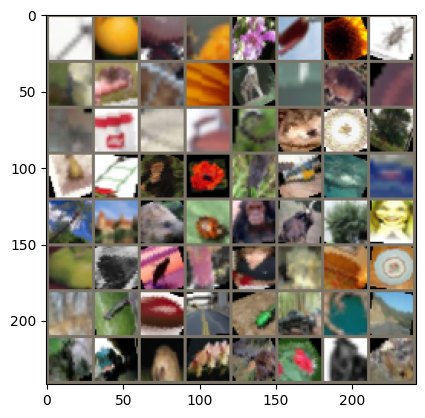

In [225]:
# Check DataLoader
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(train_loader))
out = make_grid(inputs)

imshow(out)

In [226]:
class BottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, expansion =1):
        super(BottleNeck, self).__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.GELU()
        self.stride = stride

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)

        return out

class Net(nn.Module):#마음만은 열넷 v4.0.5
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = BottleNeck(3, 64)#32*32*3 -> 32*32*64
        self.conv2 = BottleNeck(64, 64, stride=2)#32*32*64 -> 16*16*64
        self.conv3 = BottleNeck(64, 64, stride=2)#16*16*64 -> 8*8*64
        self.conv4 = nn.Conv2d(64, 100, kernel_size=1, stride=1, padding=0, bias=False)#8*8*64 -> 8*8*100
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))#8*8*100 -> 1*1*100
        self.fc1 = nn.Linear(64, 100)#1*1*100 -> 1*1*100
        #initiate weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        

        return x
        


In [227]:
for batch, (X,y)in enumerate(train_loader):
    print(batch)
    print(X.shape)
    print(y.shape)
    break

0
torch.Size([64, 3, 28, 28])
torch.Size([64])


In [228]:

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 128 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct



In [229]:
device =  "cpu"
print("Using {} device".format(device))

model = Net().to(device)


loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

Using cpu device


In [230]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

summary(model, (3, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             192
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              GELU-3           [-1, 64, 28, 28]               0
            Conv2d-4           [-1, 64, 28, 28]          36,864
       BatchNorm2d-5           [-1, 64, 28, 28]             128
              GELU-6           [-1, 64, 28, 28]               0
            Conv2d-7           [-1, 64, 28, 28]           4,096
       BatchNorm2d-8           [-1, 64, 28, 28]             128
              GELU-9           [-1, 64, 28, 28]               0
       BottleNeck-10           [-1, 64, 28, 28]               0
           Conv2d-11           [-1, 64, 28, 28]           4,096
      BatchNorm2d-12           [-1, 64, 28, 28]             128
             GELU-13           [-1, 64, 28, 28]               0
           Conv2d-14           [-1, 64,

In [231]:

base_correct = 0
for t in range(args['epochs']):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    print("test loop")
    correct = test_loop(valid_loader, model, loss_fn)
    if correct > base_correct:
        print('save model')
        torch.save(model.state_dict(), 'model2.pt')
        base_correct = correct
print("Done!")

Epoch 1
-------------------------------
loss: 4.600526  [    0/40000]
loss: 4.402947  [ 8192/40000]
loss: 4.334218  [16384/40000]
loss: 4.199866  [24576/40000]
loss: 4.171324  [32768/40000]
test loop
Test Error: 
 Accuracy: 7.1%, Avg loss: 4.091901 

save model
Epoch 2
-------------------------------
loss: 3.989483  [    0/40000]


KeyboardInterrupt: 

In [ ]:
import pandas as pd
model.load_state_dict(torch.load('model2.pt'))
id_list = []
pred_list = []
_id = 0
model.eval()
with torch.no_grad():
    for x in test_loader:
        preds = model(x)
        preds = preds.argmax(1)
        for pred in preds:
            id_list.append(_id)
            pred_list.append(pred.item())
            _id += 1

res = pd.DataFrame({
    'id_idx': id_list,
    'label': pred_list
}) 

res.sort_values(by='id_idx', inplace=True)

res.to_csv('./result.csv', index=False) 